# Ames Housing Data - Housing Price Prediction

### Notebook #2 - EDA Feature Analysis

In [189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [190]:
# import train data

df = pd.read_csv('../Data/train.csv')

In [191]:
# check data imported

df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [309]:
# check the min, max of SalePrice

df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

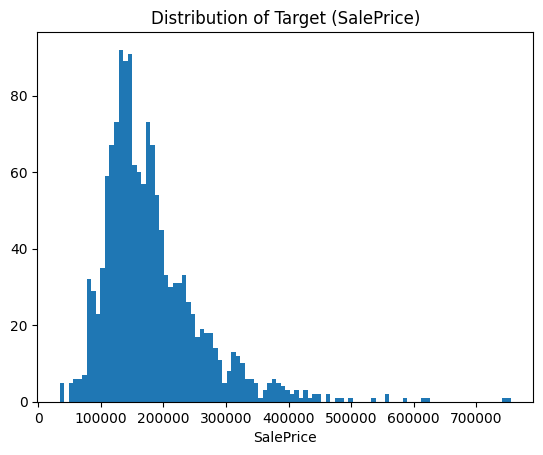

In [192]:
# plot the distribution of the target feature, SalePrice, to check if the distribution is normal

plt.hist(df['SalePrice'], bins=100);
plt.title('Distribution of Target (SalePrice)')
plt.xlabel('SalePrice');

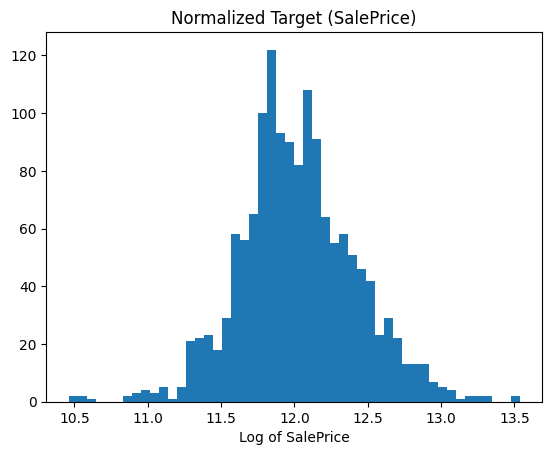

In [193]:
# the target feature is not normally distributed. To improve model performance, take the log to normalize the distribution

target_normalized = np.log(df['SalePrice'])

# plot the logged SalePrice to check new distribution

plt.hist(target_normalized, bins=50)
plt.title('Normalized Target (SalePrice)')
plt.xlabel('Log of SalePrice');

In [194]:
# !pip install dython

### Check the correlation between categorical ('object' datatypes) features.

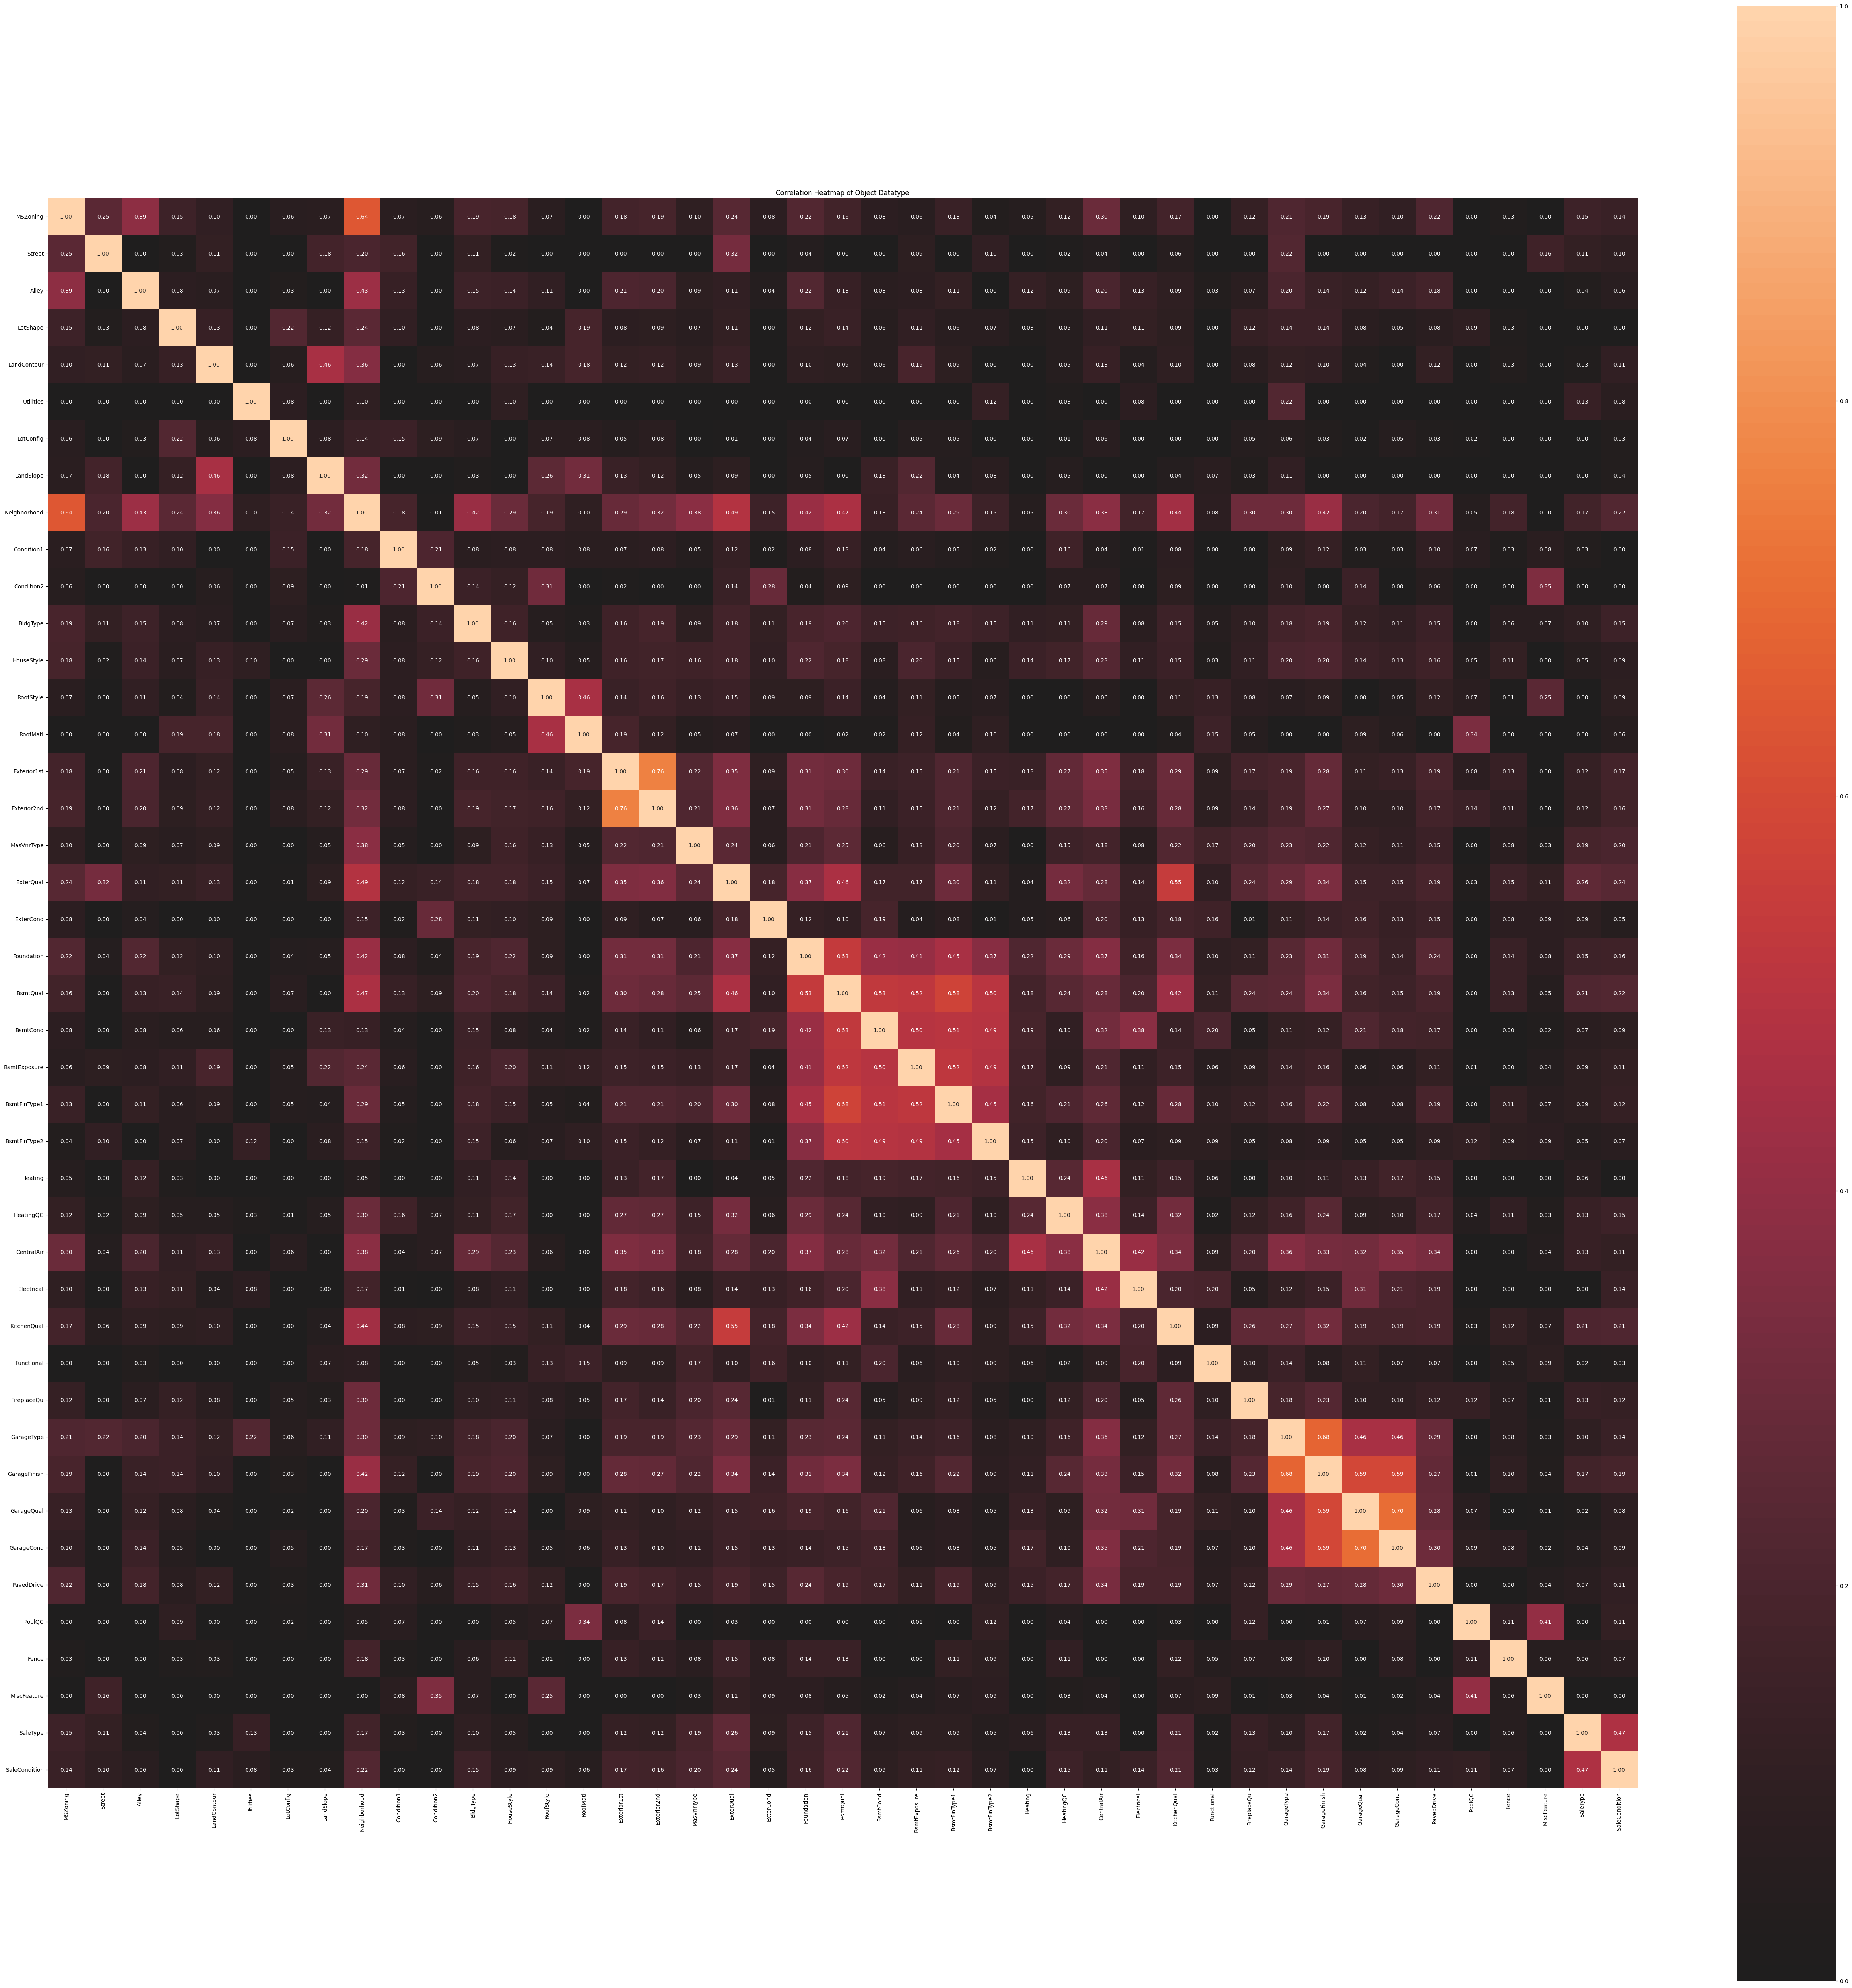

In [195]:
from dython.nominal import associations

associations(df.select_dtypes('object'), title='Correlation Heatmap of Object Datatype');

In [196]:
# calculate the correlations of all features to each other and save to dataframe

corr_all = associations(df, compute_only=True)['corr']

In [197]:
# sort by the highest correlation to SalePrice
# rename column names

sorted_corr = pd.DataFrame(corr_all['SalePrice'].abs().sort_values(ascending=False))
sorted_corr.columns = ['Corr to SalePrice']
sorted_corr = sorted_corr.reset_index().rename(columns = {'index':'Feature'})
sorted_corr

,Feature,Corr to SalePrice
0,SalePrice,1.000000
1,OverallQual,0.790982
2,Neighborhood,0.738630
3,GrLivArea,0.708624
4,ExterQual,0.690933
...,...,...
76,Id,0.021917
77,MiscVal,0.021190
78,BsmtHalfBath,0.016844
79,Utilities,0.014314


In [198]:
# !pip install tabulate

In [199]:
# convert the dataframe into markdown format

from tabulate import tabulate

print(tabulate(sorted_corr, tablefmt="pipe", headers="keys", showindex=False))

| Feature       |   Corr to SalePrice |
|:--------------|--------------------:|
| SalePrice     |           1         |
| OverallQual   |           0.790982  |
| Neighborhood  |           0.73863   |
| GrLivArea     |           0.708624  |
| ExterQual     |           0.690933  |
| BsmtQual      |           0.681905  |
| KitchenQual   |           0.675721  |
| GarageCars    |           0.640409  |
| GarageArea    |           0.623431  |
| TotalBsmtSF   |           0.613581  |
| 1stFlrSF      |           0.605852  |
| FullBath      |           0.560664  |
| GarageFinish  |           0.553059  |
| FireplaceQu   |           0.542181  |
| TotRmsAbvGrd  |           0.533723  |
| YearBuilt     |           0.522897  |
| YearRemodAdd  |           0.507101  |
| Foundation    |           0.506328  |
| GarageType    |           0.499204  |
| MasVnrArea    |           0.472614  |
| Fireplaces    |           0.466929  |
| BsmtFinType1  |           0.459141  |
| HeatingQC     |           0.442154  |


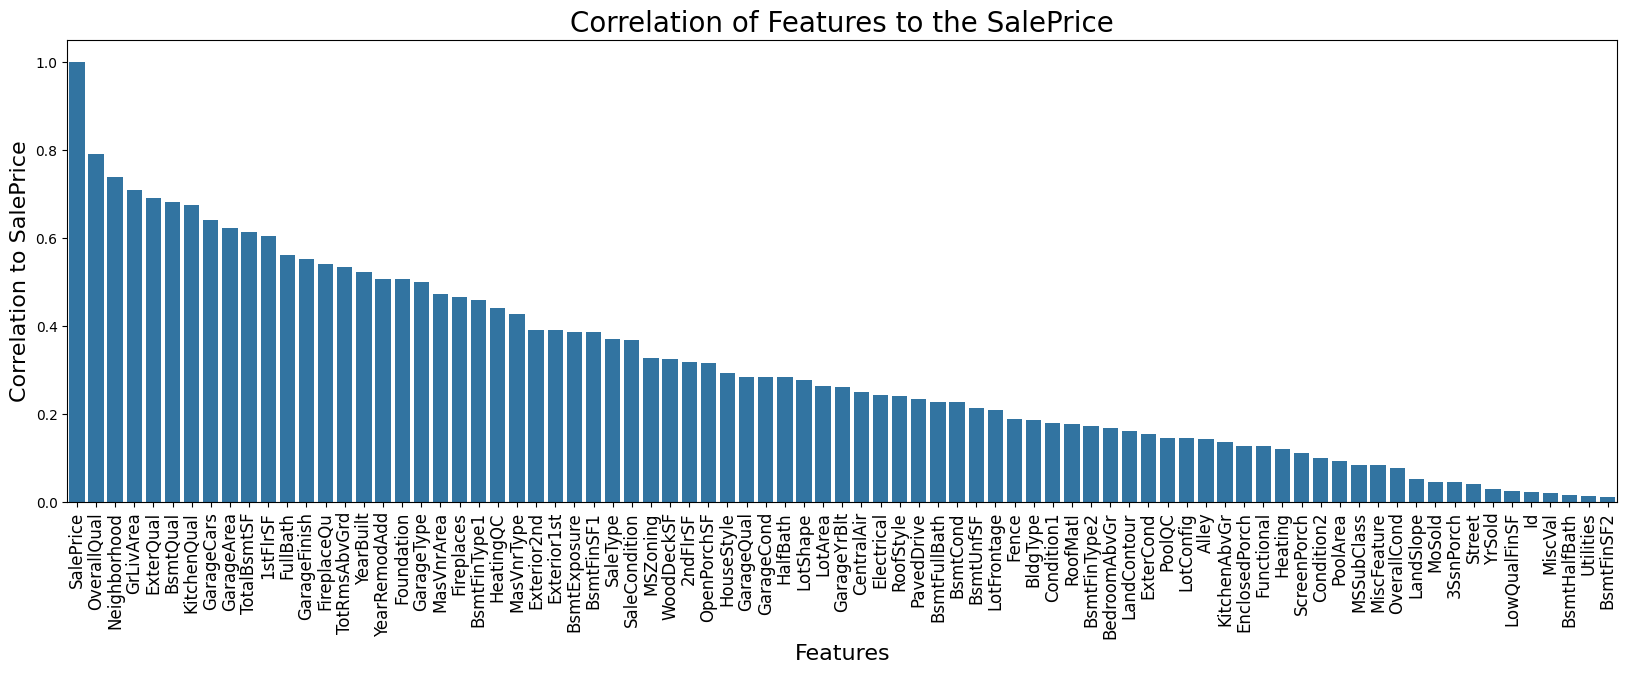

In [200]:
plt.figure(figsize=(20,6))
sns.barplot(data=sorted_corr,x='Feature',y='Corr to SalePrice')
plt.title('Correlation of Features to the SalePrice', fontsize=20)
plt.ylabel('Correlation to SalePrice', fontsize=16)
plt.xlabel('Features', fontsize=16)
plt.xticks(rotation=90, fontsize=12);

In [201]:
# checking for multicollinearity amongst the Garage-related features
# extract the list of columns that mention Garage

garage_columns = [col for col in df.columns if 'Garage' in col]
garage_columns

['GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond']

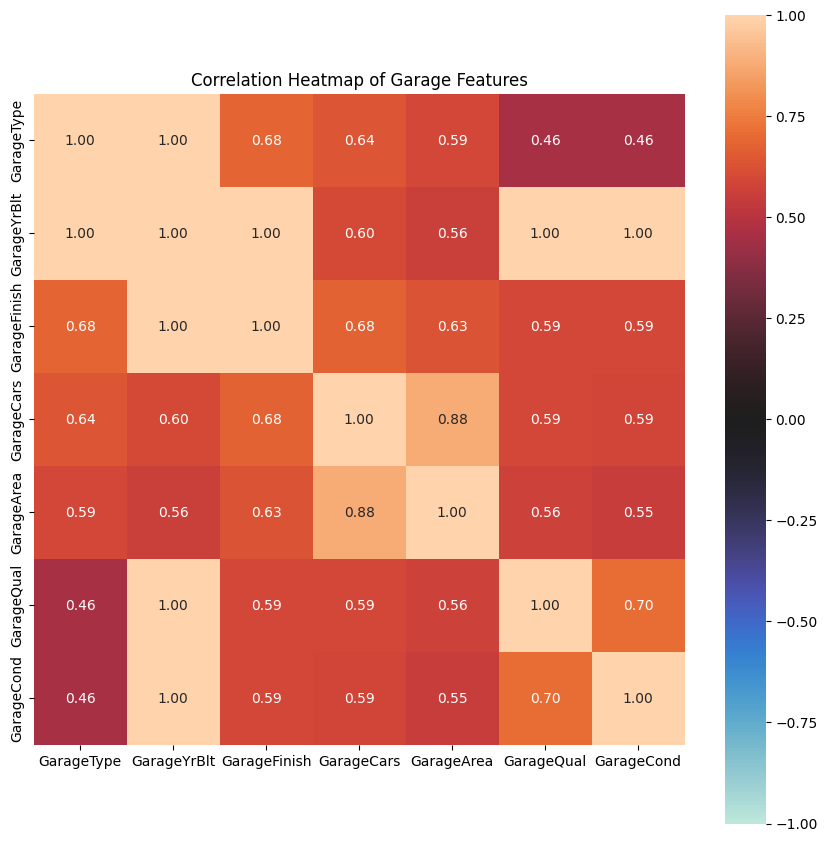

In [202]:
# check the correlation heatmap for only the Garage features

associations(df[garage_columns], title='Correlation Heatmap of Garage Features');

In [203]:
# investigate why the correlation between GarageType and GarageYrBlt is 1
# use OHE to encode GarageType first

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn import set_config
set_config(transform_output='pandas')


ohe = OneHotEncoder(sparse_output=False)

preprocessor = ColumnTransformer([
  ('ohe', ohe, ['GarageType'])
], remainder='passthrough', verbose_feature_names_out=False)

In [204]:
# fit and transform the df using the OHE

df_proc = preprocessor.fit_transform(df)

In [205]:
# create a list that contains only the columns that were created by the OneHotEncoding of the GarageType feature

garage_cols = [col for col in df_proc.columns if 'GarageType' in col]

garage_cols

['GarageType_2Types',
 'GarageType_Attchd',
 'GarageType_Basment',
 'GarageType_BuiltIn',
 'GarageType_CarPort',
 'GarageType_Detchd',
 'GarageType_nan']

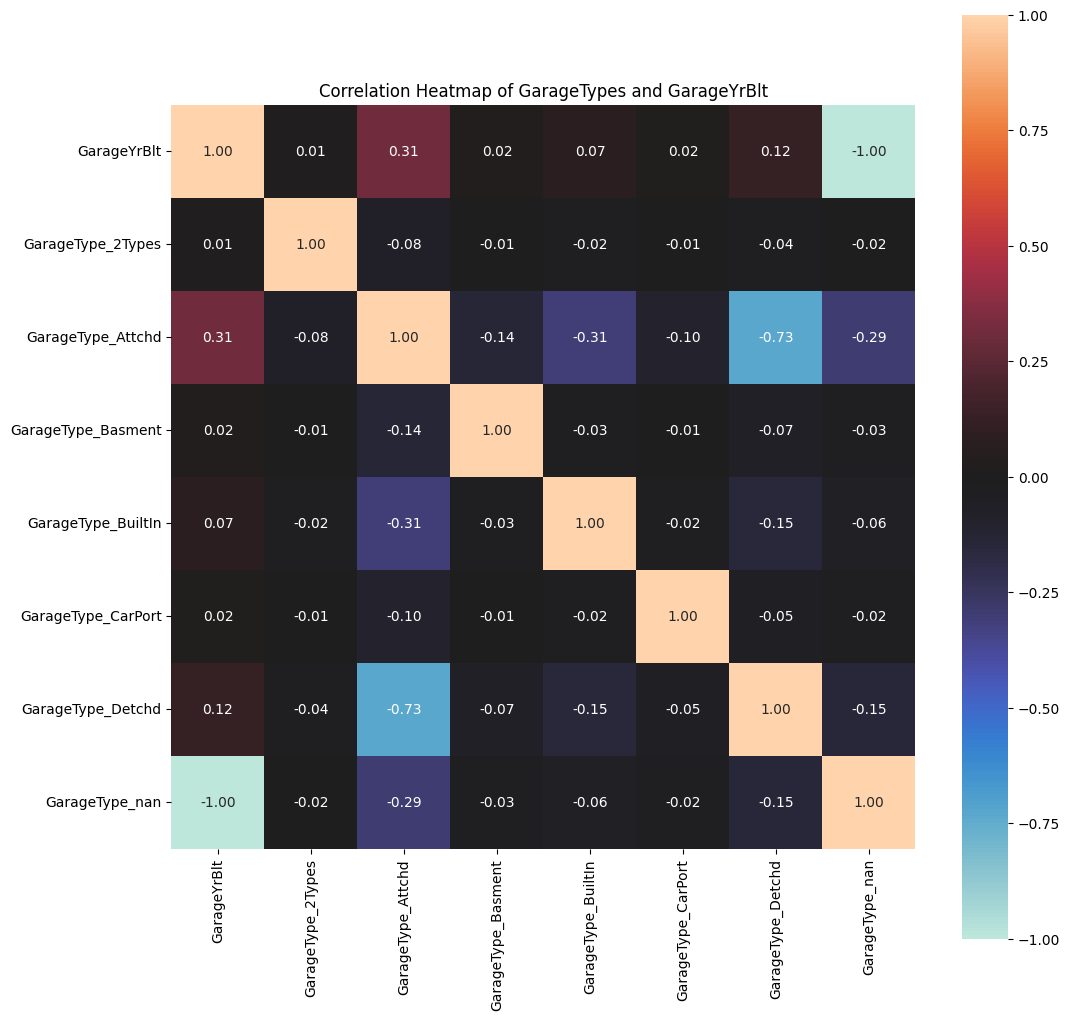

In [206]:
# use dython associations to create a heatmap for GarageYrBlt vs the GarageTypes

associations(df_proc[(['GarageYrBlt'] + garage_cols)], title='Correlation Heatmap of GarageTypes and GarageYrBlt');

The 1.0 correlation is between GarageType_nan and GarageYrBlt. The perfect correlation now makes sense, because if the home does not have a garage, it would be NaN in both features, therefore, the correlation is exact. This also brings to my attention that if multiple features are related to the same part of a home, such as garage, or basement, it will cause features to have high correlation with each other because it will be NaN in all those features.

In [207]:
# checking for multicollinearity amongst the Basement-related features
# extract the list of columns that mention Basement

bsmt_columns = [col for col in df.columns if 'Bsmt' in col]
bsmt_columns

['BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath']

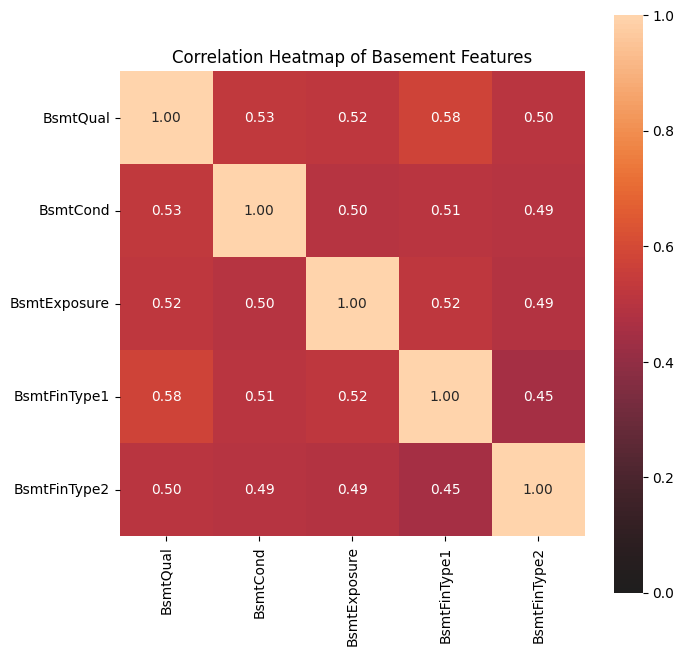

In [208]:
# check the correlation of the Basement features of the Object datatype

associations(df[bsmt_columns].select_dtypes('object'), title='Correlation Heatmap of Basement Features');

As expected, the basement features do show significant correlations to each other. I am sure this is partly due to having NaN's in multiple features for the same home when the home does not have a basement. However, these features are important to the model, and should not be dropped. Furthermore, the multicollinearity is still within an acceptable range, so I will mitigate the concern of multicollinearity by using models that conduct feature selection. 

### Checking other correlations between features and the target, SalePrice

Text(0.5, 1.0, 'Sale Price vs. Ground Living Area')

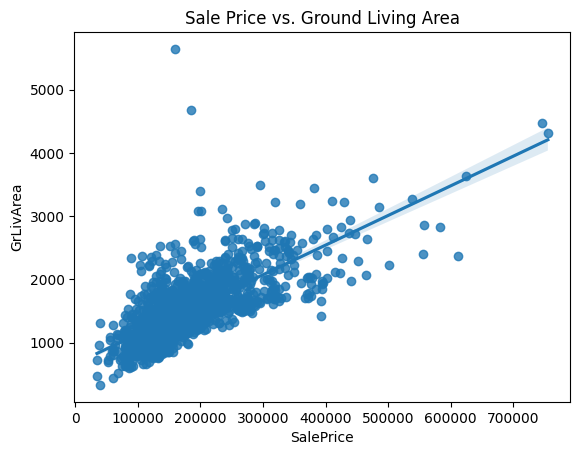

In [209]:
# Examine the correlation between SalePrice and the Ground Living Area by plotting a seaborn regression plot.
# I expect that the SalePrice will increase as the living area square footage increases.

sns.regplot(data=df, x='SalePrice', y='GrLivArea')
plt.title('Sale Price vs. Ground Living Area')

As expected, the regplot shows a positive correlation between SalePrice and GrLivArea. The line represents the best-fit linear regression model, and the shaded area is the confidence interval, which represents the level of uncertainty of the model. The confidence interval here is fairly narrow, which means that model is fairly confident. How tightly the datapoints are clustered around the regression line speaks to the strength of the relationship. The observations surround the line, however, they are not tightly clustered, so GrLivArea is in no way a perfect predictor of SalePrice. 

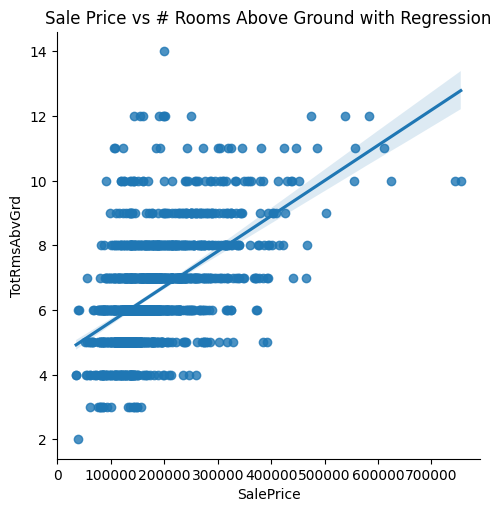

In [210]:
# to understand the correlation between the number of total rooms above ground, I wil use the seaborn lmplot
# the lmplot also fits a regression line to the scatter plot and helps to show the linear relationship between the variables

sns.lmplot(data=df, x='SalePrice', y='TotRmsAbvGrd')
plt.title('Sale Price vs # Rooms Above Ground with Regression');

There is definitely a positive correlation between SalePrice and the number of Rooms Above Ground, but the correlation is not as strong as with GrLivArea. This is in line with the Pearson's R. 

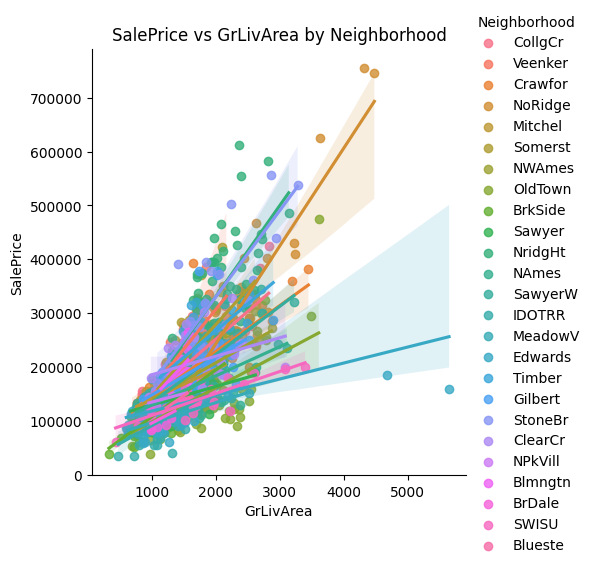

In [211]:
# Neighborhood has the second highest correlation with the SalePrice.
# I expect that the neighborhood can either boost or lower the SalePrice on top of the other features.
# to test my hypothesis, I will use the seaborn FacetGrid to plot SalePrice against GrLivArea, but with neighborhoods as the subsets.


sns.lmplot(data=df, x="GrLivArea", y="SalePrice", hue="Neighborhood")
plt.title('SalePrice vs GrLivArea by Neighborhood');

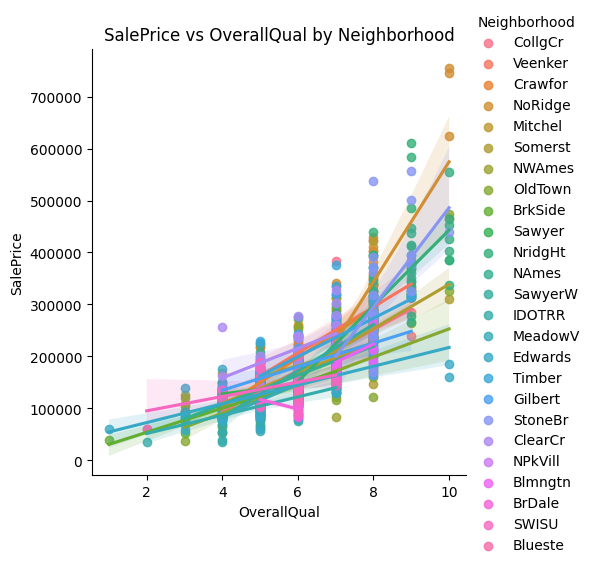

In [212]:
# Neighborhood has the second highest correlation with the SalePrice.
# I expect that the neighborhood can either boost or lower the SalePrice on top of the other features.
# to test my hypothesis, I will use the seaborn FacetGrid to plot SalePrice against GrLivArea, but with neighborhoods as the subsets.


sns.lmplot(data=df, x="OverallQual", y="SalePrice", hue="Neighborhood")
plt.title('SalePrice vs OverallQual by Neighborhood');

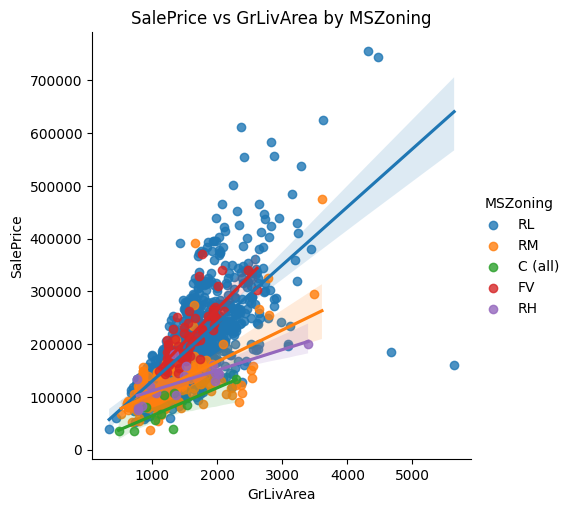

In [213]:
# Visualizing the impact of MSZoning on SalePrice vs GrLivArea

sns.lmplot(data=df, x="GrLivArea", y="SalePrice", hue="MSZoning")
plt.title('SalePrice vs GrLivArea by MSZoning');

Observation: There does appear to be a segmentation effect of MSZoning on the linear correlation between SalePrice and GrLivArea.
I wonder if there is a strong correlation between MSZoning and Neighborhood. 

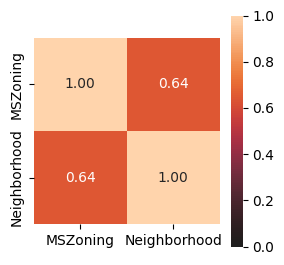

{'corr':               MSZoning  Neighborhood
 MSZoning      1.000000      0.640629
 Neighborhood  0.640629      1.000000,
 'ax': <Axes: >}

In [214]:
# Checking the correlation between MSZoning and Neighborhood

associations(df[['MSZoning','Neighborhood']])

There is indeed a significant correlation between MSZoning and Neighborhood. This makes sense, because the homes in the same neighborhood are also likely to be under the same zoning, since both are geographic boundaries. However, the correlation is still far from 1.0, so both features bring important information to the model.

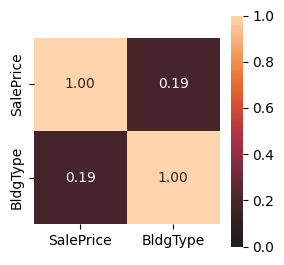

{'corr':            SalePrice  BldgType
 SalePrice   1.000000  0.185833
 BldgType    0.185833  1.000000,
 'ax': <Axes: >}

In [215]:
associations(df[['SalePrice','BldgType']])

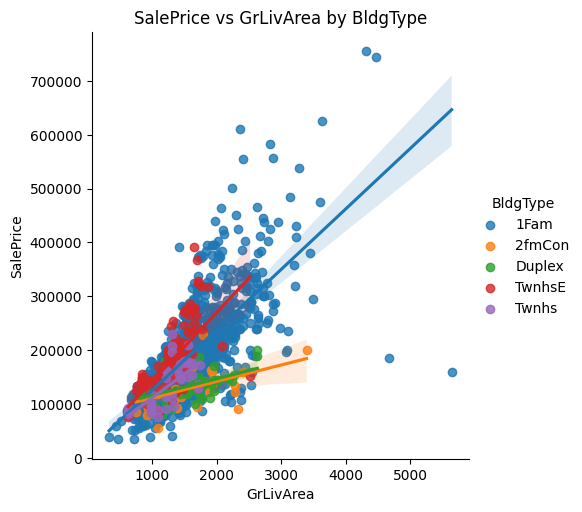

In [216]:
# Visualizing the impact of BldgType on SalePrice vs GrLivArea

sns.lmplot(data=df, x="GrLivArea", y="SalePrice", hue="BldgType")
plt.title('SalePrice vs GrLivArea by BldgType');


Similar to MSZoning, Sale Price vs Ground Living Area show different regression lines when segmented by Building Type. 

This plot leads to a few interesting observations:

1. The slope is much steeper for single family homes (1Fam) than for two-family conversion homes (2FmCon). Two-family conversion homes were originally built as one-family dwelling, but later converted into 2 dwellings. The steeper slope means that there is a stronger relationship between SalePrice and GrLivArea for 1Fam than for 2FamCon. This indicates that even if the homes are the same size, a 2FmCon correlates to a lower SalePrice than a 1Fam. This does not necessarily mean that converting a single family home into a 2 family conversion will decrease the SalePrice, because correlation does not mean causation, and there may be confounding factors, but this would be something interesting to look into for a future project. 

2. The size and the price of a two-family conversion are limited. Whereas single-family homes have a wide range of values, with outliers in all directions, two-family conversions are limited in size and price. Based on my research, two-family conversions are typically sold as 1 single building. This means that the types of single family homes that are usually converted into two-family dwellings are not too big. This makes sense, because conversions are usually conducted in high-density areas to meet housing demand. It seems unlikely that a high-end luxury home would ever be converted. 

3. The regression lines for 2famCon and Duplex are almost the same. This signals that the correlation between area and price is similar for these two building types. This is unsurprising, because 2famCon is basically a Duplex, just converted after the fact.

4. Townhouse End Units (TownhsE), interestingly, have the steepest slope. This means that they exhibit the highest price per square feet. However, their area is limited, so we don't see any high square footages that can be observed in single family homes. 

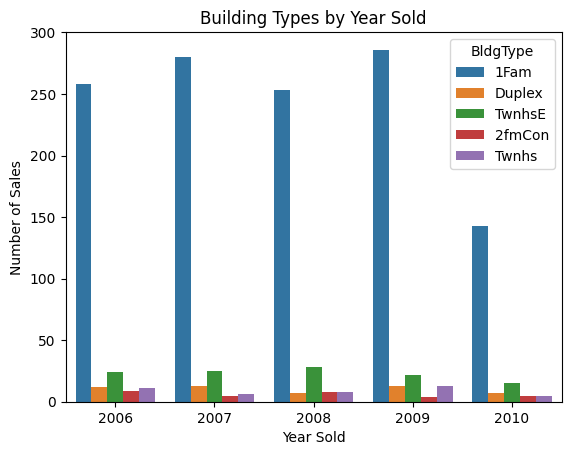

In [217]:
# Checking if the distribution of building type varies by the year sold

sns.countplot(df, x="YrSold", hue="BldgType", stat="count")
plt.title('Building Types by Year Sold')
plt.ylabel('Number of Sales')
plt.xlabel('Year Sold');

It seems like there was an overall decrease in sales in 2010. Other than that, it is difficult to tell the difference between years by gauging visually. I will use a groupby to try to understand the statistical variation.

In [218]:
# for each year, calculate the percentage for every building type out of all sales
# use groupby to total the count by YrSold

bldg_percent_year = pd.DataFrame(df.groupby(['YrSold','BldgType'])['BldgType'].count() / df.groupby(['YrSold'])['BldgType'].count())
bldg_percent_year

BldgType
YrSold BldgType          
2006   1Fam      0.821656
       2fmCon    0.028662
       Duplex    0.038217
       Twnhs     0.035032
       TwnhsE    0.076433
2007   1Fam      0.851064
       2fmCon    0.015198
       Duplex    0.039514
       Twnhs     0.018237
       TwnhsE    0.075988
2008   1Fam      0.832237
       2fmCon    0.026316
       Duplex    0.023026
       Twnhs     0.026316
       TwnhsE    0.092105
2009   1Fam      0.846154
       2fmCon    0.011834
       Duplex    0.038462
       Twnhs     0.038462
       TwnhsE    0.065089
2010   1Fam      0.817143
       2fmCon    0.028571
       Duplex    0.040000
       Twnhs     0.028571
       TwnhsE    0.085714

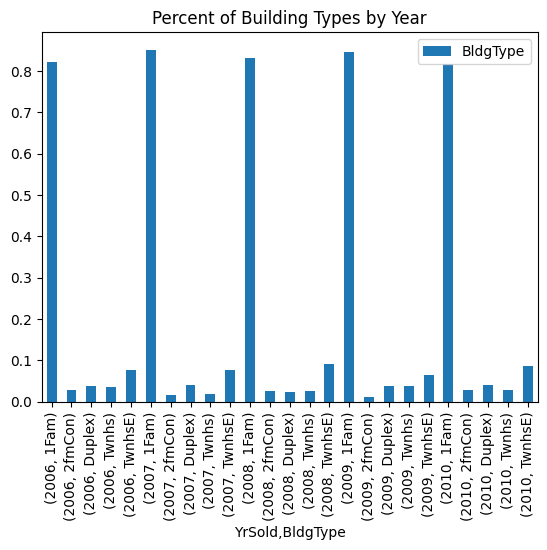

In [219]:
# plot the above grouped dataframe to see there are any trends

bldg_percent_year.plot(kind='bar')
plt.title('Percent of Building Types by Year');

Based on the above bar plot, the proportion of buildings types being sold each year remains fairly consistent, even if the overall number of sales fluctuates year over year. 

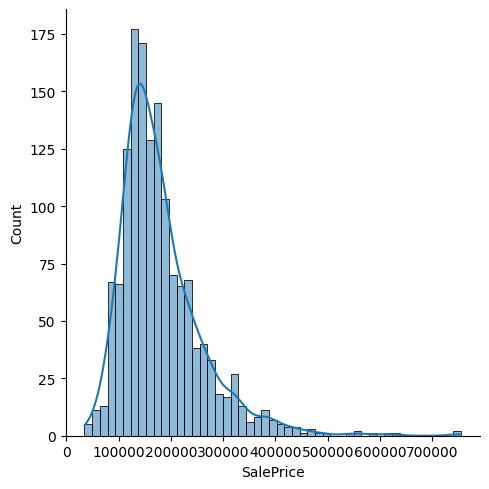

In [220]:
# checking the distribution of the target, SalePrice

sns.displot(data=df, x="SalePrice", kde=True);

The distribution of the target is skewed to the right. For the best model performance, I want to transform the distribution into a more normal distribution. I will take the log of the SalePrice to normalize the distribution.

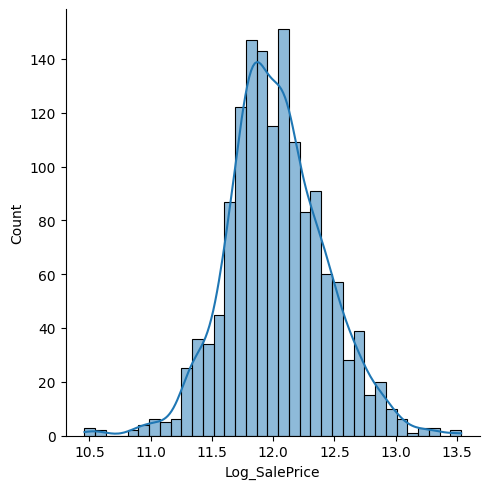

In [221]:
# add a new column to the df that is the log of the SalePrice

df['Log_SalePrice'] = np.log(df['SalePrice'])

# plot the distribution again to check if normality has improved

sns.displot(data=df, x="Log_SalePrice", kde=True);

The SalePrice is now normally distributed. I will conduct this transformation for my model in the preprocessing pipeline. Noting that I will need to take the exponential of the model predictions in order to revert them to back to normal sales prices. 

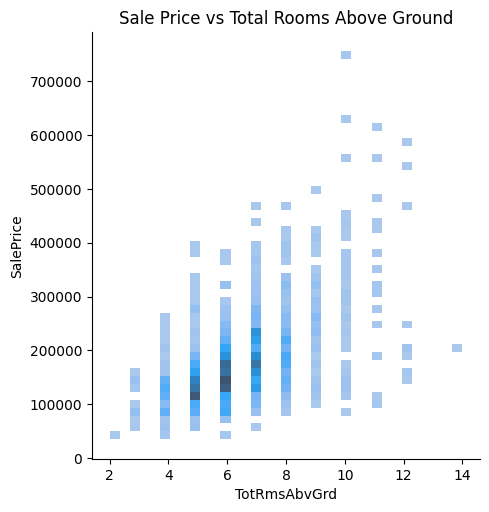

In [222]:
# checking the correlation between SalePrice and Total rooms above ground

sns.displot(data=df, x="TotRmsAbvGrd", y="SalePrice")
plt.title('Sale Price vs Total Rooms Above Ground');

There appears to be a positive correlation, but range is wide, so it is difficult to conclude any specific insights. 

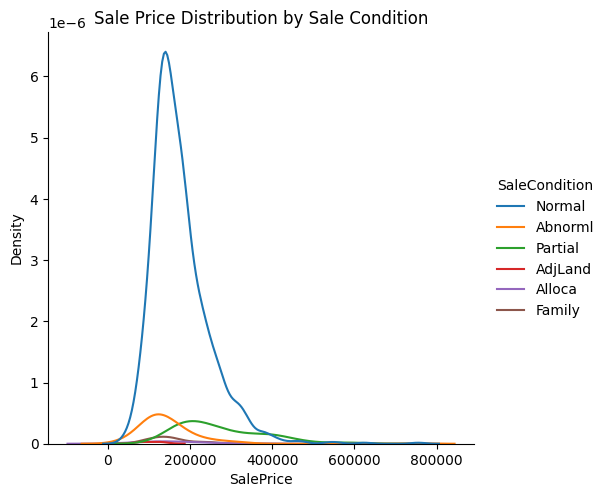

In [223]:
# checking the distribution of SalePrice under different sale conditions

sns.displot(data=df, x="SalePrice", hue="SaleCondition", kind="kde")
plt.title('Sale Price Distribution by Sale Condition');

The different sale conditions have slightly different distributions. The peak for an Abnormal Sale occurs at a lower SalePrice than the peak for Partial Sales. This indicates that different sale conditions do correlate differently to SalePrice. 

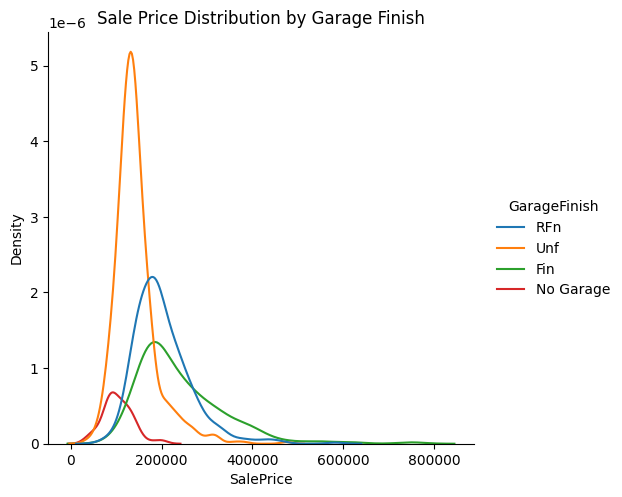

In [224]:
# Visualize the correlation between the distribution of SalePrice according to the different Garage Finishes

df['GarageFinish'] = df['GarageFinish'].fillna('No Garage')

sns.displot(data=df, x="SalePrice", hue="GarageFinish", kind="kde")
plt.title('Sale Price Distribution by Garage Finish');

The plot shows notably different distributions for the 4 garage types. The homes that don't have a garage correlate to sale prices that are much lower than those with a garage. The lines on the plot are a smooth representation of the data distribution. The peaks of each kde plot line is the value with the highest frequency, or the mode. 

In [252]:
# calculate the mode for each type of Garage Finish

garage_finish_modes = pd.DataFrame(df.groupby('GarageFinish')['SalePrice'].agg(lambda x: x.mode().iloc[0]))
garage_finish_modes

,SalePrice
GarageFinish,
Fin,185000
No Garage,84500
RFn,190000
Unf,135000


In [248]:
# turn the dataframe into a readme table

print(tabulate(garage_finish_modes, tablefmt="pipe", headers="keys", showindex=True))

| GarageFinish   |   SalePrice |
|:---------------|------------:|
| Fin            |      185000 |
| No Garage      |       84500 |
| RFn            |      190000 |
| Unf            |      135000 |


In line with the displot, the lowest mode is No Garage, and the next one is Unfinished Garage. Surprisingly, the next highest is Finished Garage, not Rough Finish. I did not expect the Rough Finish to have a higher mode than Finished. However, looking back to the displot, finished garage homes have a fatter tail towards the higher end of Sale Price. This indicates that although the mode may be lower, there is a greater chance for a home with a finished garage to correlate to a higher sale price than a home with a rough finished garage.

/Users/annahan/Documents/GitHub/learning-fuze/live_class_W1D2_0125/.conda/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 69.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<Axes: xlabel='SalePrice', ylabel='SaleCondition'>

/Users/annahan/Documents/GitHub/learning-fuze/live_class_W1D2_0125/.conda/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 68.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


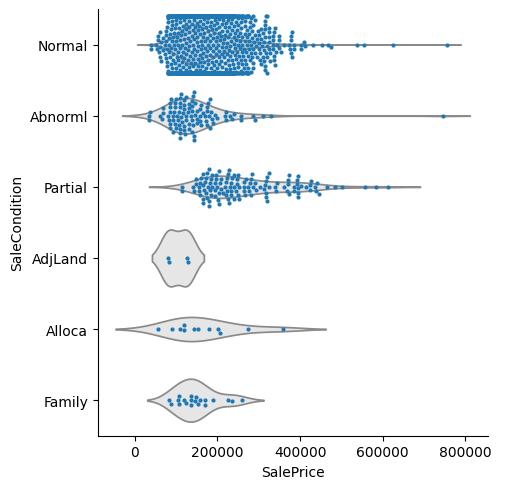

In [253]:
# checking the correlation between SaleCondition and SalePrice
# use the seaborn categorical violin plot to show the distribution shape
# use the seaborn swarm plot to understand the data spread and the sample size

sns.catplot(data=df, x="SalePrice", y="SaleCondition", kind="violin", color=".9", inner=None)
sns.swarmplot(data=df, x="SalePrice", y="SaleCondition", size=3)

/Users/annahan/Documents/GitHub/learning-fuze/live_class_W1D2_0125/.conda/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 5.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


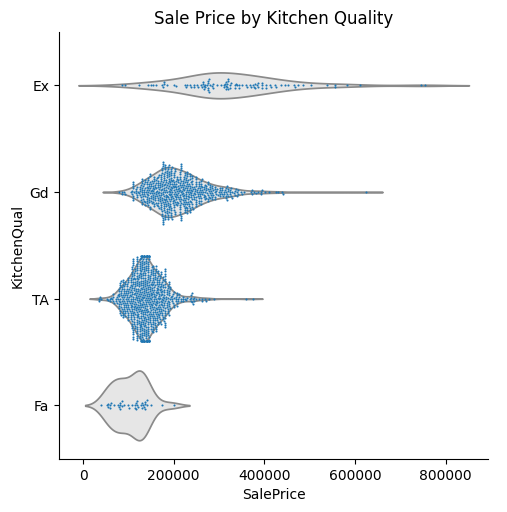

In [263]:
# checking the correlation between KitchenQuality and SalePrice
# use the seaborn categorical violin plot to show the distribution shape
# use the seaborn swarm plot to understand the data spread and the sample sizes

sns.catplot(data=df, x="SalePrice", y="KitchenQual", kind="violin", color=".9", inner=None, order=['Ex','Gd','TA','Fa'])
sns.swarmplot(data=df, x="SalePrice", y="KitchenQual", size=1.5)
plt.title('Sale Price by Kitchen Quality');

- From the above plot, it is notable that the sample size for Excellent and Fair are much smaller than those for Good and Typical/Average.
- Overall, there is definitely a positive correlation between a better quality kitchen and the sale price of the home.
- It is interesting to see that an Excellent quality kitchen correlates to a very wide range of sales prices.
- Like I mentioned earlier, the quality indicators offer a unique perspective on the home, because these can capture aspects of the home that may not be quantifiable, but can still influence the purchasing behavior or a home buyer, thereby, affecting the sale price.

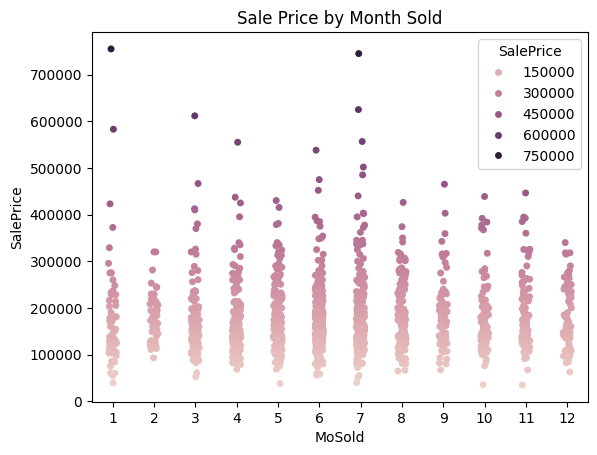

In [273]:
# Visualizing the sale price by month sold

sns.stripplot(data=df, x='MoSold', y='SalePrice', hue='SalePrice')
plt.title('Sale Price by Month Sold');

- More homes are sold during the summer. 
- I tried switching the hue as several other variables, but there didn't seem to a any patterns to note. 

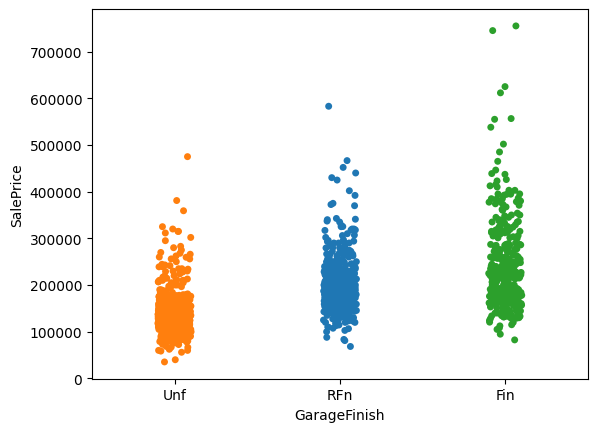

In [275]:
# visualizing the garage finishes via a stripplot

sns.stripplot(data=df, x='GarageFinish', y='SalePrice', hue='GarageFinish', order=['Unf','RFn','Fin']);

- This plot show more apparently that finished garages correspond to higher sale prices than roughly finished garages.

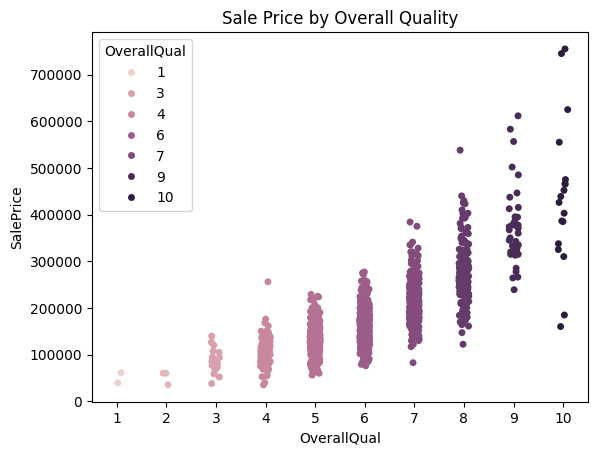

In [276]:
# plot the sales price according to overall quality

sns.stripplot(data=df, x='OverallQual', y='SalePrice', hue='OverallQual')
plt.title('Sale Price by Overall Quality');

- The above stripplot visualizes the correlation between OverallQual and the SalePrice. It is clear that a higher overall quality corresponds to a higher sales price. However, the distribution is more sparse and varied on the high end of the spectrum. 

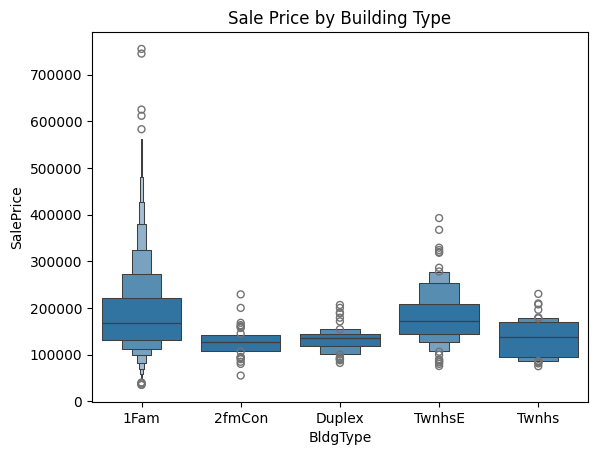

In [277]:
# plot a boxplot to understand the distribution of sale price by building type

sns.boxenplot(data=df, x="BldgType", y="SalePrice")
plt.title('Sale Price by Building Type');

- single family home has the largest range of prices
- 2-family conversions, duplex and townhomes all have a much more limited range of prices

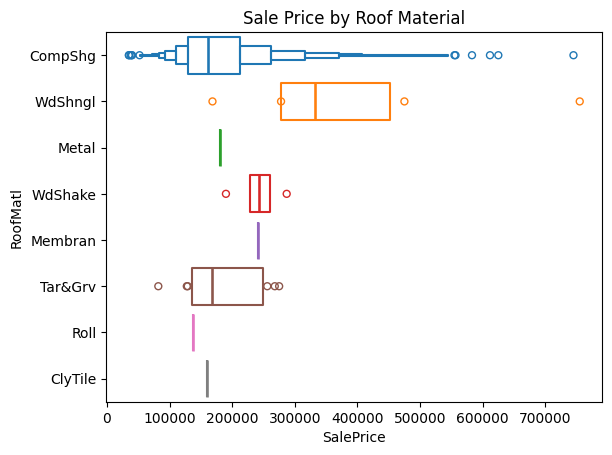

In [278]:
# Checking the distribution of sale price by roof material

sns.boxenplot(data=df, x="SalePrice", y="RoofMatl", hue="RoofMatl", fill=False)
plt.title('Sale Price by Roof Material');

- some types of roofing material have very few samples. It will be difficult to come to any conclusions with so few samples.

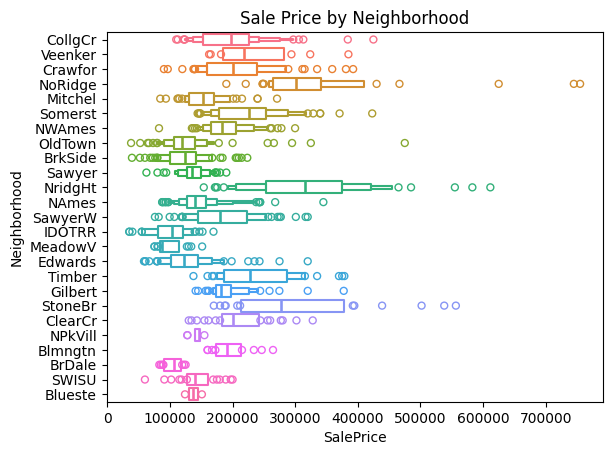

In [279]:
# examine the sale price distribution by neighborhood

sns.boxenplot(data=df, x="SalePrice", y="Neighborhood", hue="Neighborhood", fill=False)
plt.title('Sale Price by Neighborhood');

- some neighborhoods correspond to higher sale prices, but there are many outliers. 

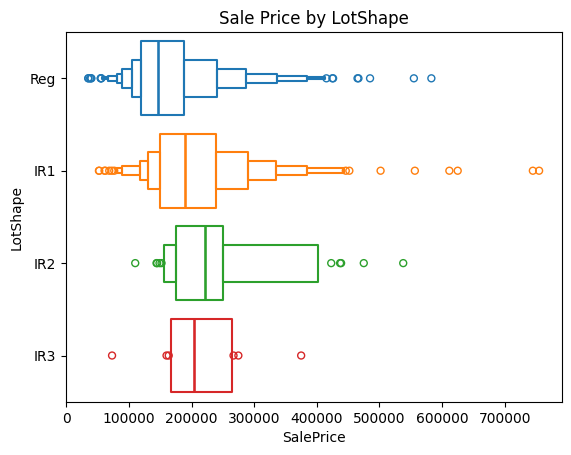

In [280]:
# check for correlation between lot shape and sale price

sns.boxenplot(data=df, x="SalePrice", y="LotShape", hue="LotShape", fill=False)
plt.title('Sale Price by LotShape');

- the 3 levels of irregular lot shapes correspond to higher sale prices than regular lot shape. 
- I hypothesize that this is because larger lots are more likely to be irregular, and larger lots correspond to higher prices.

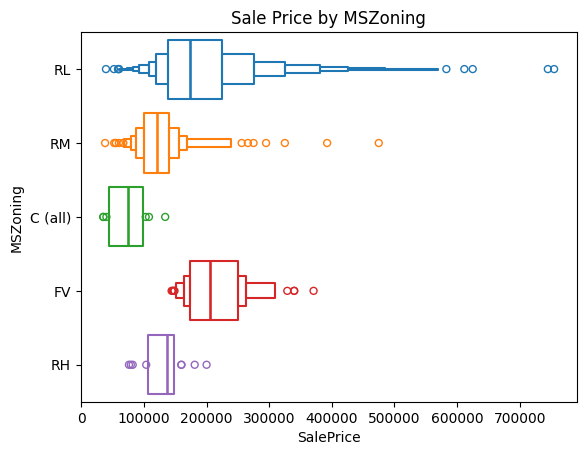

In [281]:
# analyze the distribution of sale price by MSZoning

sns.boxenplot(data=df, x="SalePrice", y="MSZoning", hue="MSZoning", fill=False)
plt.title('Sale Price by MSZoning');

- Zoning does appear to have an impact on the sale price distribution. Again, like I mentioned earlier, there is a an overlap between Neighborhoods and MSZoning, as relate to geographic boundaries. 

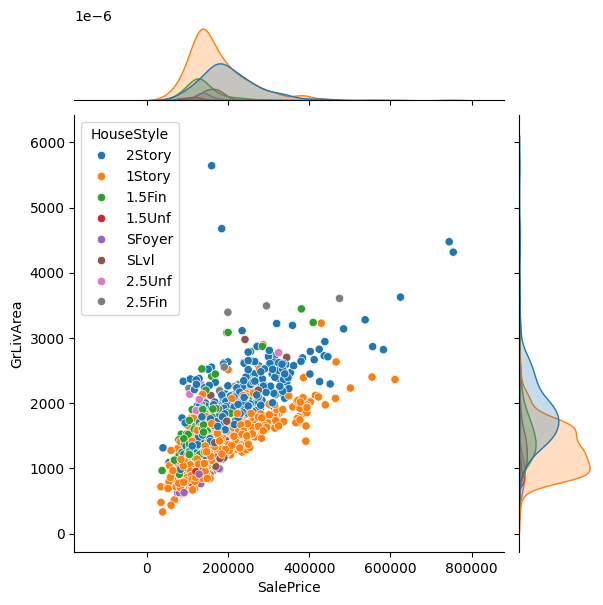

In [283]:
# check the interaction between multiple variables: ground living area, sale price and house style using seaborn jointplot

sns.jointplot(data=df, x="SalePrice", y="GrLivArea", hue="HouseStyle");

- the most visible trend from the above plot is that 1 story homes' most frequent sale price is lower than that of 2 story homes. Also, 1 story homes correspond to smaller above ground living area than 2 story homes. This is expected, since more floors means greater area. 

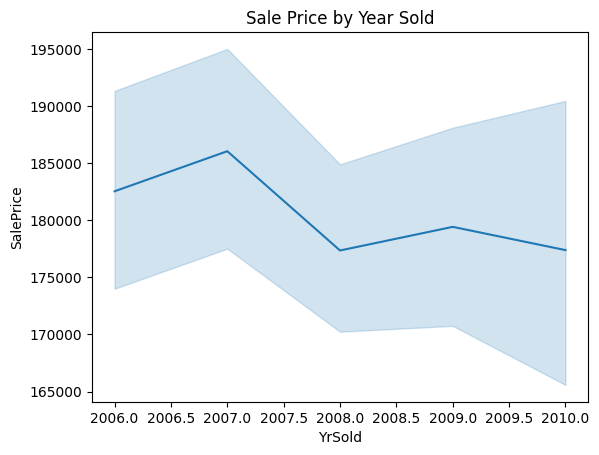

In [284]:
# plotting the sale price by year sold

sns.lineplot(data=df, x='YrSold', y='SalePrice')
plt.title('Sale Price by Year Sold');

- There is a slightly negative trend between sale price and year sold. However, the shaded area, which is the confidence interval, is very wide. This indicates that the correlation is not very strong, and is not enough to be conclusive. 

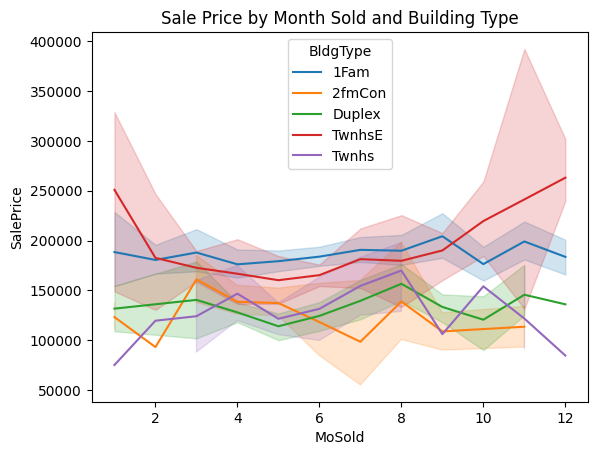

In [285]:
# see if there are any trends in sale price in different months sold, using building type as the subset

sns.lineplot(data=df, x='MoSold', y='SalePrice', hue='BldgType')
plt.title('Sale Price by Month Sold and Building Type');

- Townhouse End Unit corresponds to higher sale prices during the winter months. However, the confidence interval, as indicated by the shaded area, is significant. This means that we do not have enough correlation to be confident about this relationship. The only conclusion we can draw from this plot is the fact that single family homes typically correlate to higher sales prices than the other types of building. 

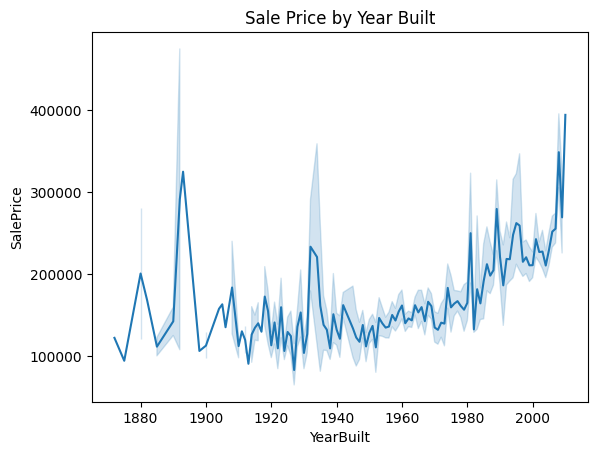

In [286]:
# plot the sale price by year built to see the overall trend

sns.lineplot(data=df, x="YearBuilt", y="SalePrice")
plt.title('Sale Price by Year Built');

- As anticipated, there is a positive correlation between year built and the sale price. However, the correlation does not appear to be linear. Rather, the upward trend only starts around 1950, and homes built prior to 1950 have large fluctuations in pricing. Possible explanations could be historical or renovated buildings have a higher value. 
- Between 1950 and 2010, the correlation stabilizes into a consistent upward trend.
- There is spike in home prices in homes built after 2010. This could be because of the cost of modern amenities, and demand for newer properties.

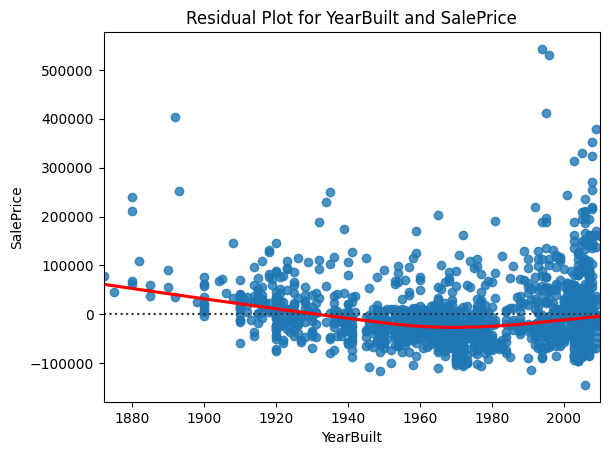

In [308]:
# use the seaborn residual plot to check if the correlation models well using a linear regression

sns.residplot(data=df, x="YearBuilt", y="SalePrice", lowess=True, line_kws=dict(color="r"))
plt.title('Residual Plot for YearBuilt and SalePrice');

- The red line in the plot is the LOESS smoother, a non-parametric regression method, which means that it dynamically learns patterns from data instead of using a set function. If LOESS line is flat at 0, it would mean that residuals are randomly scattered and that there is no systematic bias. However, a curve in the LOESS line, as seen in the above plot, indicates that there is a non-linear relationship. 
- For homes built before 1960, the model increasingly overestimates home prices, this suggests that the model is unable to account for additional factors that affect sale price, possibly costs such as depreciation or major repairs. Around 1960-1980, the LOESS line is the flattest, which means that the model is the most stable, although there is still bias, since it is consistently overestimating the sale price. After 1980s, the model starts to increasingly underestimate sale price. This could be because the demand of newer home is higher, or the cost of modern amenities in newer homes drive the sale price higher than in older homes. 